<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [16]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.01
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 500
batch_size = 64
replay_buffer_size = 500_000
target_update_freq = 10

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
#device = torch.device("cpu")

# 1) Q-Network (PyTorch)

In [17]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [18]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

# 3) ε-Greedy Policy

In [19]:
# Epsilon-greedy
def epsilon_greedy(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        state_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(state_t)
        return torch.argmax(q_values, dim=1).item()

In [8]:
import numpy as np, torch
assert torch.cuda.is_available()
q_net = q_net.to("cuda").eval()

@torch.no_grad()
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    s = torch.as_tensor(state, dtype=torch.float32, device="cuda").reshape(1, -1).contiguous()
    q = q_net(s)
    return int(q.argmax(dim=1).item())

def test_epsilon_greedy(env, n_actions, trials_uniform=20000, trials_eps=20000, eps_val=0.3):
    # 0) sanity: model/device
    p = next(q_net.parameters())
    assert p.is_cuda and p.dtype == torch.float32

    # use a fixed state
    state, _ = env.reset()
    state = np.asarray(state, dtype=np.float32)

    # --- Monkey-patch forward so we know the greedy action exactly ---
    orig_forward = q_net.forward
    @torch.no_grad()
    def fake_forward(x):
        # Q = [0,1,2,...,n_actions-1] for every row -> greedy = n_actions-1
        B = x.shape[0]
        return torch.arange(n_actions, device=x.device, dtype=torch.float32).unsqueeze(0).repeat(B, 1)
    q_net.forward = fake_forward

    try:
        greedy = n_actions - 1

        # 1) ε = 0 -> always greedy
        for _ in range(1000):
            a = epsilon_greedy(state, 0.0)
            assert a == greedy, f"ε=0 should be greedy, got {a}"

        # 2) ε = 1 -> roughly uniform over actions
        counts = np.zeros(n_actions, dtype=int)
        for _ in range(trials_uniform):
            a = epsilon_greedy(state, 1.0)
            counts[a] += 1
        expected = trials_uniform / n_actions
        tol = 5 * np.sqrt(expected)  # 5-sigma binomial tolerance
        max_dev = np.abs(counts - expected).max()
        assert max_dev < tol, f"ε=1 not uniform enough. counts={counts}, tol={tol:.1f}"

        # 3) ε = eps_val -> P(return greedy) = (1-ε) + ε*(1/nA)
        target_p = (1 - eps_val) + eps_val * (1.0 / n_actions)
        hits = 0
        for _ in range(trials_eps):
            a = epsilon_greedy(state, eps_val)
            if a == greedy:
                hits += 1
        emp_p = hits / trials_eps
        std = np.sqrt(target_p * (1 - target_p) / trials_eps)
        assert abs(emp_p - target_p) < 5 * std, f"ε calibration off. emp={emp_p:.4f}, tgt={target_p:.4f}"

        print("✅ ε-greedy tests passed:",
              f"uniform max dev={max_dev:.1f} (tol={tol:.1f}),",
              f"ε={eps_val} emp={emp_p:.4f} vs tgt={target_p:.4f}")

    finally:
        # restore original forward
        q_net.forward = orig_forward

# --- run tests ---
test_epsilon_greedy(env, n_actions)


✅ ε-greedy tests passed: uniform max dev=110.3 (tol=408.2), ε=0.3 emp=0.7971 vs tgt=0.8000


In [20]:
# Train step (experience replay)
def train_dqn():

    import numpy as np

    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # stack cleanly; all entries are plain obs arrays (not (obs, info))
    states      = torch.as_tensor(np.stack(states), dtype=torch.float32, device=device)
    actions     = torch.as_tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards     = torch.as_tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.as_tensor(np.stack(next_states), dtype=torch.float32, device=device)
    dones       = torch.as_tensor(dones, dtype=torch.float32, device=device)

    # Q(s,a)
    q_vals = q_net(states).gather(1, actions).squeeze(1)  # (B,)

    # Target: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_vals, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward:  -200.0
Reward: 

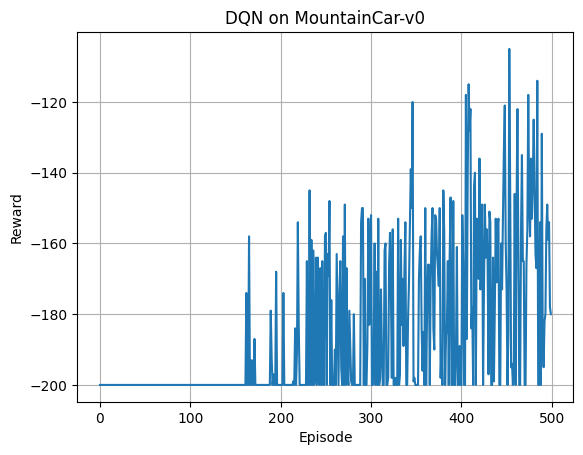

In [22]:
# ---- GPU pre-flight (keep in the same cell as the MAIN loop) ----
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
assert torch.cuda.is_available()

# avoid fused TF32 matmul/cublasLt quirks in notebooks
os.environ["NVIDIA_TF32_OVERRIDE"] = "0"
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision("high")

# ensure nets live on CUDA in fp32
q_net = q_net.to("cuda").float()
target_net = target_net.to("cuda").float().eval()

# make Linear params contiguous (defensive)
for net in (q_net, target_net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data = m.weight.data.contiguous()
            if m.bias is not None:
                m.bias.data = m.bias.data.contiguous()

# sanity: parameters are finite
with torch.no_grad():
    for n, p in q_net.named_parameters():
        if not torch.isfinite(p).all():
            raise RuntimeError(f"Non-finite param in {n}")

# ---- cuBLAS-free action selection (batch=1 pointwise reductions) ----
@torch.no_grad()
def _linear_pointwise_b1(v_1xD: torch.Tensor, W_OxD: torch.Tensor, b_O: torch.Tensor | None):
    """
    v_1xD: [1, D] cuda float32 contiguous
    W_OxD: [O, D] cuda float32 contiguous
    b_O  : [O]    cuda float32 contiguous or None
    -> [1, O]
    """
    v = v_1xD.squeeze(0)           # [D]
    y = (W_OxD * v).sum(dim=1)     # [O]  (elementwise mul + reduce, no cuBLAS)
    if b_O is not None:
        y = y + b_O
    return y.unsqueeze(0)          # [1, O]

def q_forward_b1_pointwise(s_1xD: torch.Tensor) -> torch.Tensor:
    x = s_1xD.to("cuda", dtype=torch.float32).contiguous()
    x = F.relu(_linear_pointwise_b1(x, q_net.fc1.weight, q_net.fc1.bias))
    x = F.relu(_linear_pointwise_b1(x, q_net.fc2.weight, q_net.fc2.bias))
    x = _linear_pointwise_b1(x, q_net.fc3.weight, q_net.fc3.bias)
    return x  # [1, n_actions]

@torch.no_grad()
def epsilon_greedy(state, eps: float):
    if np.random.rand() < eps:
        return env.action_space.sample()
    s = torch.as_tensor(state, dtype=torch.float32, device="cuda").reshape(1, -1).contiguous()
    q = q_forward_b1_pointwise(s)   # no cuBLAS in the greedy path
    return int(q.argmax(dim=1).item())

# quick dry run on CUDA (should pass)
with torch.no_grad():
    _ = q_forward_b1_pointwise(torch.zeros(1, state_dim, device="cuda", dtype=torch.float32))




# MAIN loop
rewards_dqn = []
steps_done = 0

for episode in range(num_episodes):
    state, _ = env.reset()  # <-- FIX: unpack (obs, info), store ONLY obs
    total_reward = 0.0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # store ONLY obs arrays
        replay_buffer.append((state, action, reward, next_state, float(done)))

        state = next_state
        total_reward += reward

        train_dqn()

        if steps_done > 0 and steps_done % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())
        steps_done += 1

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)

    print("Reward: ", total_reward)

# Plot
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on MountainCar-v0")
plt.grid()
plt.show()

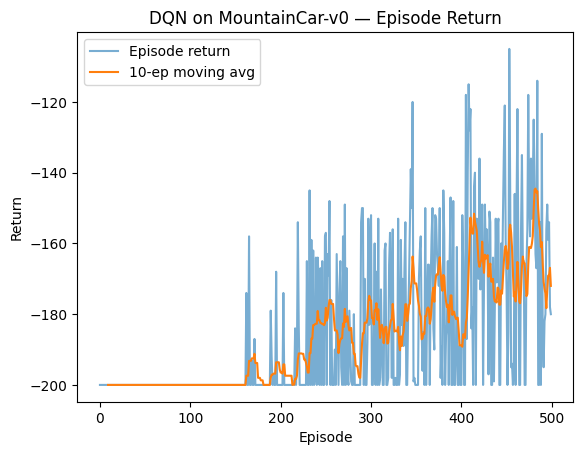

In [23]:
# 1) Episode vs Return
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rewards_dqn, label="Episode return", alpha=0.6)
if len(rewards_dqn) >= 10:
    ma = np.convolve(rewards_dqn, np.ones(10)/10, mode="valid")
    plt.plot(range(9, 9+len(ma)), ma, label="10-ep moving avg")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("DQN on MountainCar-v0 — Episode Return")
plt.legend()
plt.show()


C:\Users\juanc\AppData\Local\Temp\ipykernel_58512\1404706900.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(False):


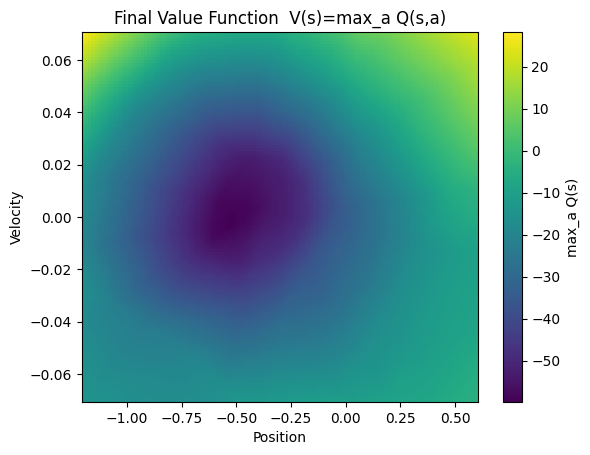

In [24]:
# 2) Final Value Function: V(s) = max_a Q(s,a) over (position, velocity)
import torch

def plot_value_heatmap(eval_net, env, device, n_pos=121, n_vel=121, chunk=8192):
    # Build a grid over the state space
    low, high = env.observation_space.low, env.observation_space.high
    pos = np.linspace(low[0], high[0], n_pos, dtype=np.float32)      # position
    vel = np.linspace(low[1], high[1], n_vel, dtype=np.float32)      # velocity
    P, V = np.meshgrid(pos, vel, indexing="xy")                       # X=pos, Y=vel

    grid = np.stack([P.ravel(), V.ravel()], axis=1).astype(np.float32)

    # Batched evaluation on GPU (no tiny batch=1 calls)
    eval_net = eval_net.to(device).float().eval()
    qmax_chunks = []
    with torch.no_grad(), torch.cuda.amp.autocast(False):
        t = torch.from_numpy(grid).to(device)
        for i in range(0, t.shape[0], chunk):
            q = eval_net(t[i:i+chunk])                 # [B, n_actions]
            qmax_chunks.append(q.max(dim=1).values)
    Z = torch.cat(qmax_chunks).view(n_vel, n_pos).cpu().numpy()       # rows=vel, cols=pos

    # Heatmap
    plt.figure()
    plt.pcolormesh(P, V, Z, shading="auto")
    plt.colorbar(label="max_a Q(s)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Final Value Function  V(s)=max_a Q(s,a)")
    plt.show()

# use target_net if available (smoother), else q_net
eval_net = target_net if "target_net" in globals() else q_net
plot_value_heatmap(eval_net, env, device)


# Deriverable questions

The Agent learns relatively quickly, as the plot shows that it starts to achieve its goal by episode 150. However, compared with the tile coding, the NN learn more slowly for this system. Additionally, the tile coding approach presents a more stable solution and is easily tunable for this specific problem. In conclusion, for linear problems with small states, a tile coding approach remains a viable option.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [ ]:
# In order to install Luna Lander ue the next

# conda install -c conda-forge swig pybox2d pygame -y
#%pip install "gymnasium[box2d]"

Note: you may need to restart the kernel to use updated packages.


In [36]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.0001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 500_000
target_update_freq = 10

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
#device = torch.device("cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [19]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [20]:
# Epsilon-greedy
def epsilon_greedy(state, eps):
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        state_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_net(state_t)
        return torch.argmax(q_values, dim=1).item()

In [21]:
# Train step (experience replay)
def train_dqn():

    import numpy as np

    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # stack cleanly; all entries are plain obs arrays (not (obs, info))
    states      = torch.as_tensor(np.stack(states), dtype=torch.float32, device=device)
    actions     = torch.as_tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards     = torch.as_tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.as_tensor(np.stack(next_states), dtype=torch.float32, device=device)
    dones       = torch.as_tensor(dones, dtype=torch.float32, device=device)

    # Q(s,a)
    q_vals = q_net(states).gather(1, actions).squeeze(1)  # (B,)

    # Target: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        targets = rewards + gamma * next_q * (1.0 - dones)

    loss = loss_fn(q_vals, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# ---- GPU pre-flight (keep in the same cell as the MAIN loop) ----
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
assert torch.cuda.is_available()

# avoid fused TF32 matmul/cublasLt quirks in notebooks
os.environ["NVIDIA_TF32_OVERRIDE"] = "0"
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision("high")

# ensure nets live on CUDA in fp32
q_net = q_net.to("cuda").float()
target_net = target_net.to("cuda").float().eval()

# make Linear params contiguous (defensive)
for net in (q_net, target_net):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data = m.weight.data.contiguous()
            if m.bias is not None:
                m.bias.data = m.bias.data.contiguous()

# sanity: parameters are finite
with torch.no_grad():
    for n, p in q_net.named_parameters():
        if not torch.isfinite(p).all():
            raise RuntimeError(f"Non-finite param in {n}")

# ---- cuBLAS-free action selection (batch=1 pointwise reductions) ----
@torch.no_grad()
def _linear_pointwise_b1(v_1xD: torch.Tensor, W_OxD: torch.Tensor, b_O: torch.Tensor | None):
    """
    v_1xD: [1, D] cuda float32 contiguous
    W_OxD: [O, D] cuda float32 contiguous
    b_O  : [O]    cuda float32 contiguous or None
    -> [1, O]
    """
    v = v_1xD.squeeze(0)           # [D]
    y = (W_OxD * v).sum(dim=1)     # [O]  (elementwise mul + reduce, no cuBLAS)
    if b_O is not None:
        y = y + b_O
    return y.unsqueeze(0)          # [1, O]

def q_forward_b1_pointwise(s_1xD: torch.Tensor) -> torch.Tensor:
    x = s_1xD.to("cuda", dtype=torch.float32).contiguous()
    x = F.relu(_linear_pointwise_b1(x, q_net.fc1.weight, q_net.fc1.bias))
    x = F.relu(_linear_pointwise_b1(x, q_net.fc2.weight, q_net.fc2.bias))
    x = _linear_pointwise_b1(x, q_net.fc3.weight, q_net.fc3.bias)
    return x  # [1, n_actions]

@torch.no_grad()
def epsilon_greedy(state, eps: float):
    if np.random.rand() < eps:
        return env.action_space.sample()
    s = torch.as_tensor(state, dtype=torch.float32, device="cuda").reshape(1, -1).contiguous()
    q = q_forward_b1_pointwise(s)   # no cuBLAS in the greedy path
    return int(q.argmax(dim=1).item())

# quick dry run on CUDA (should pass)
with torch.no_grad():
    _ = q_forward_b1_pointwise(torch.zeros(1, state_dim, device="cuda", dtype=torch.float32))


# MAIN loop
rewards_dqn = []
steps_done = 0

for episode in range(num_episodes):
    state, _ = env.reset()  # <-- FIX: unpack (obs, info), store ONLY obs
    total_reward = 0.0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # store ONLY obs arrays
        replay_buffer.append((state, action, reward, next_state, float(done)))

        state = next_state
        total_reward += reward

        train_dqn()

        if steps_done > 0 and steps_done % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())
        steps_done += 1

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)

    print("Reward: ", total_reward)

# Plot
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on LunarLander-v2")
plt.grid()
plt.show()

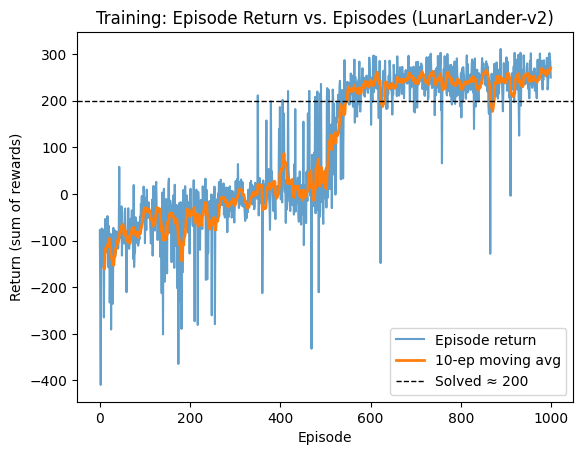

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rewards_dqn, label="Episode return", alpha=0.7)
if len(rewards_dqn) >= 10:
    ma = np.convolve(rewards_dqn, np.ones(10)/10, mode="valid")
    plt.plot(range(9, 9+len(ma)), ma, label="10-ep moving avg", linewidth=2)
plt.axhline(200, ls="--", lw=1, color="k", label="Solved ≈ 200")  # LunarLander ref
plt.xlabel("Episode")
plt.ylabel("Return (sum of rewards)")
plt.title("Training: Episode Return vs. Episodes (LunarLander-v2)")
plt.legend()
plt.show()


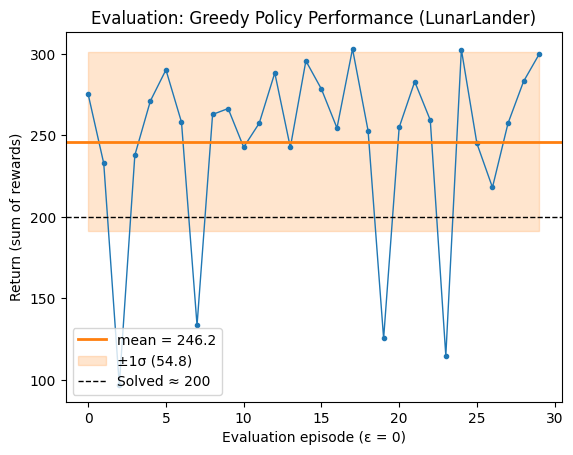

Greedy evaluation over 30 eps — mean: 246.17, std: 54.79, min: 96.9, max: 303.1


In [34]:
import gymnasium as gym
import torch, numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")
q_net = q_net.to(device).eval()  # greedy eval

# ---- safe greedy (GPU) ----
@torch.no_grad()
def greedy_action(state):
    s = torch.as_tensor(state, dtype=torch.float32, device=device).reshape(1, -1).contiguous()
    # use your cuBLAS-free path if present; otherwise force FP32 matmuls
    if 'q_forward_b1_pointwise' in globals():
        q = q_forward_b1_pointwise(s)    # elementwise + reduce (no cuBLAS)
    else:
        with torch.autocast('cuda', enabled=False):       # disable AMP/TF32 here
            q = q_net(s)
    return int(q.argmax(dim=1).item())

def _make_env(env_name, render=False):
    if render:
        # windowed rendering
        return gym.make(env_name, render_mode="human")
    else:
        # no render: don't pass render_mode at all
        return gym.make(env_name)

def evaluate_greedy(env_name="LunarLander-v3", episodes=20, render=False):
    env = _make_env(env_name, render=render)
    returns = []
    with torch.no_grad():
        for _ in range(episodes):
            s, _ = env.reset()
            done, G = False, 0.0
            while not done:
                a = greedy_action(s)
                s, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                G += r
            returns.append(G)
    env.close()
    return np.asarray(returns, dtype=np.float32)

# ---- run & plot ----
eval_returns = evaluate_greedy(episodes=30, render=False)
mean_r, std_r = float(eval_returns.mean()), float(eval_returns.std())

plt.figure()
plt.plot(eval_returns, marker="o", ms=3, lw=1)
plt.axhline(mean_r, color="C1", lw=2, label=f"mean = {mean_r:.1f}")
plt.fill_between(range(len(eval_returns)),
                 mean_r - std_r, mean_r + std_r,
                 color="C1", alpha=0.2, label=f"±1σ ({std_r:.1f})")
plt.axhline(200, ls="--", lw=1, color="k", label="Solved ≈ 200")
plt.xlabel("Evaluation episode (ε = 0)")
plt.ylabel("Return (sum of rewards)")
plt.title("Evaluation: Greedy Policy Performance (LunarLander)")
plt.legend()
plt.show()

print(f"Greedy evaluation over {len(eval_returns)} eps — "
      f"mean: {mean_r:.2f}, std: {std_r:.2f}, min: {eval_returns.min():.1f}, max: {eval_returns.max():.1f}")


# Deriverables

With a configuration of 128 neurons each, the agent learns to land consistently, as shown in the graph of reward. It takes around 400 episodes to start seeing performance in the solution. Regarding stability, the learning rate plays a fundamental role because its sensitivity causes the system to take time to tune. Thus, if the learning rate (α) is 0.01, the system does not learn, as does 0.0001. 

If we compare the LunarLanding approach with the MotainCar, first of all, 500 episodes will not be enough for the LunarLanding system to learn, even though the approach used, with 128 neurons, is due to the complexity of the environment and the number of states. With this, using NN can be useful for complex systems in unknown environments with bigger states. However, if the system is linear and has a low number of states, tile coding can be a better solution.